In [1]:
import json
import pandas as pd
import datetime as dt
import requests
import lxml.html
from lxml import html
from lxml.html.clean import Cleaner
import re
%matplotlib inline
from time import sleep
from random import randint
import csv
import matplotlib.pyplot as plt


In [2]:
# clean data
df = pd.read_csv('data/dc-housing-data-enriched.csv')

df



,Unnamed: 0,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,square,suffix,is_residential,address_geocode,latitude,longitude
0,0,2600 pennsylvania av nw unit: 0201,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,HOLLIE S WONG UNIT 201,2015-04-20,660000.0,0004N 2001,NaN,17,0004N,2001,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
1,1,2600 pennsylvania av nw unit: 0202,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,FABIOLA D J VALENCIA REVOCABLE TRUST OF 2004,2004-06-25,0.0,0004N 2002,NaN,17,0004N,2002,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
2,2,2600 pennsylvania av nw unit: 0203,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARIA E ZAVALA APT 203,2001-08-07,525000.0,0004N 2003,NaN,17,0004N,2003,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
3,3,2600 pennsylvania av nw unit: 0204,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARC PETERS APT 204,2001-10-12,550000.0,0004N 2004,NaN,17,0004N,2004,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
4,4,2600 pennsylvania av nw unit: 0301,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,NEST USA INC UNIT 755,2007-08-23,825000.0,0004N 2005,NaN,17,0004N,2005,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
5,5,2600 pennsylvania av nw unit: 0302,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,C BEYDA STE 555,2001-08-02,525000.0,0004N 2006,NaN,17,0004N,2006,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
6,6,2600 pennsylvania av nw unit: 0303,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,THERESA A SNIDER,2005-05-17,850000.0,0004N 2007,NaN,17,0004N,2007,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
7,7,2600 pennsylvania av nw unit: 0304,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,DANILO A MAIA,2013-02-01,805000.0,0004N 2008,NaN,17,0004N,2008,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
8,8,2600 pennsylvania av nw unit: 0401,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,SUSAN CLAIRE GEORGE BRODARICK REVOCABLE TRUST,2006-01-27,850000.0,0004N 2009,NaN,17,0004N,2009,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
9,9,2600 pennsylvania av nw unit: 0402,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,ANN SCHROEDER UNIT 402,2011-02-16,0.0,0004N 2010,NaN,17,0004N,2010,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850


In [3]:
#df[df.address.str.contains('1401 r st nw', na=False)]

# df.head()
# df.sale_date.max()
# df[df.square_suffix == '0004N   2005']

# df[df.sale_price > 0].sale_date.min()

df_addresses = df.sample(10000)
df_addresses['zip'] = ''
df_addresses['city'] = 'Washington'
df_addresses['state'] = 'DC'

# bulk geocoding
# https://geocoding.geo.census.gov/geocoder/locations/addressbatch;jsessionid=RCr7kx_FMfiT-V8DoGSHv9DxhjxTfPqPsSUMi-aQT6n_sbRTcri5!1894070029?form
df_addresses[['address','city','state','zip']].to_csv('2018-address-export-for-bulk-latlong.csv')

# reges to get the (.*se$|.*nw$|.*sw$|.*se$)

# try to remove anything past the last se/sw/ne/nw

#len(
# df[(~((df.address.str.endswith('nw')) | (df.address.str.endswith('ne')) | (df.address.str.endswith('sw')) | (df.address.str.endswith('se'))) & (~df.address.str.contains('unit')))] #.address.unique())

In [4]:


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252083 entries, 0 to 252082
Data columns (total 16 columns):
Unnamed: 0         252083 non-null int64
address            252082 non-null object
listing_url        252083 non-null object
neighborhood       252083 non-null object
owner              252083 non-null object
sale_date          252083 non-null object
sale_price         252083 non-null float64
square_suffix      252083 non-null object
subneighborhood    173675 non-null object
use_code           252083 non-null int64
square             252083 non-null object
suffix             252083 non-null int64
is_residential     252083 non-null bool
address_geocode    176691 non-null object
latitude           176691 non-null float64
longitude          176691 non-null float64
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 29.1+ MB


In [5]:
df.neighborhood.value_counts()

OLD CITY II                45979
FOREST HILLS               29869
CENTRAL                    20545
OLD CITY I                 16707
COLUMBIA HEIGHTS           13988
DEANWOOD                   12269
HILLCREST                   6324
BROOKLAND                   5860
PETWORTH                    5605
GEORGETOWN                  5388
CHEVY CHASE                 5091
WOODRIDGE                   4785
CONGRESS HEIGHTS            4573
BRIGHTWOOD                  4567
RANDLE HEIGHTS              4440
MOUNT PLEASANT              4284
R.L.A. SW                   3768
CAPITOL HILL                3563
FORT DUPONT PARK            3352
TRINIDAD                    3174
CLEVELAND PARK              3043
KALORAMA                    2956
GARFIELD                    2372
16TH ST. HEIGHTS            2337
ECKINGTON                   2236
ANACOSTIA                   2225
WESLEY HEIGHTS              2050
AMERICAN UNIV. PARK         2030
GLOVER PARK                 2027
MARSHALL HEIGHTS            1954
FOGGY BOTT

In [6]:
df.use_code.value_counts()

18     58261
11     31672
17     23415
16     20259
12     19499
93     14060
13     10003
94      9851
91      9376
217     8529
24      6436
192     6190
22      5011
191     3607
194     3420
23      3298
64      2857
193     1921
52      1726
21      1554
14      1322
49      1066
42       820
47       769
92       590
32       578
51       561
195      448
96       445
41       442
       ...  
365       21
86        19
69        19
88        16
66        16
31        16
34        14
165       13
82        12
27        11
196       10
85         9
87         9
37         8
73         7
36         7
35         6
265        6
95         6
53         5
465        4
71         4
117        4
43         4
126        2
76         1
33         1
189        1
116        1
127        1
Name: use_code, Length: 92, dtype: int64

In [7]:
residential = [1,2,3,11,12,13,15,16,17,19]
df[(df.use_code.isin(residential))].use_code.value_counts()

11    31672
17    23415
16    20259
12    19499
13    10003
1        70
15       36
19       30
Name: use_code, dtype: int64

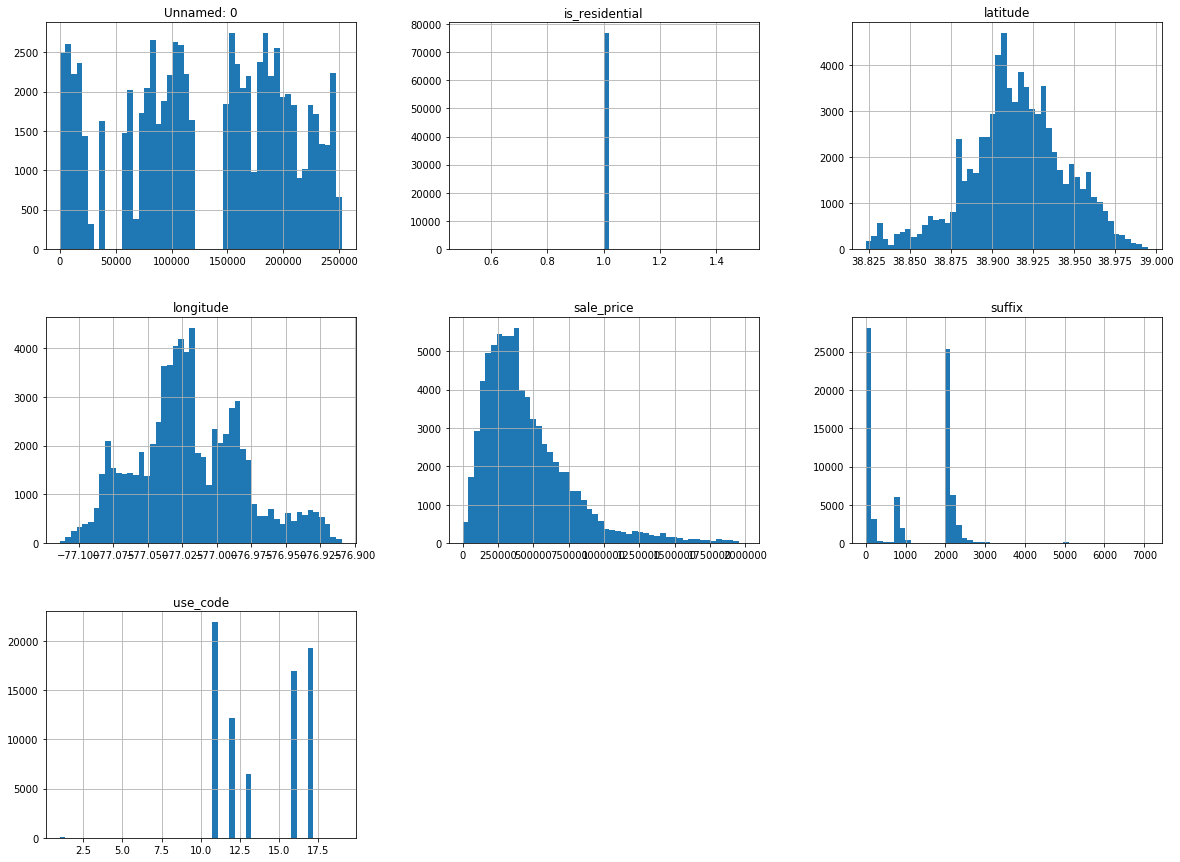

In [8]:
df = df[((df.use_code.isin(residential)) & (df.sale_price < 2000000) & (df.sale_price > 1000))]

df.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

In [10]:
df.describe()
df.info()
df.sample(10000)['address'].to_csv

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76821 entries, 0 to 252074
Data columns (total 16 columns):
Unnamed: 0         76821 non-null int64
address            76820 non-null object
listing_url        76821 non-null object
neighborhood       76821 non-null object
owner              76821 non-null object
sale_date          76821 non-null object
sale_price         76821 non-null float64
square_suffix      76821 non-null object
subneighborhood    59804 non-null object
use_code           76821 non-null int64
square             76821 non-null object
suffix             76821 non-null int64
is_residential     76821 non-null bool
address_geocode    73682 non-null object
latitude           73682 non-null float64
longitude          73682 non-null float64
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 9.5+ MB


<bound method Series.to_csv of 112479                      3625 yuma st nw
209057         1909 rosedale st ne  unit: 2
17800              1922 12th st nw  unit: 1
105025    4200 cathedral ave nw  unit: 1001
246086                       838 yuma st se
169013                     809 euclid st nw
163506                   1317 juniper st nw
160611         1495 newton st nw  unit: 406
88610                          1711 c st se
427                 2515 k st nw  unit: 305
114796             3409 broad branch ter nw
182640      738 longfellow st nw  unit: 111
7518            1601 18th st nw  unit: 1016
200202                     1211 morse st ne
168484          1303 clifton st nw  unit: 1
243815        1110 savannah st se  unit: 22
206556                    2620 evarts st ne
183720                       6520 6th st nw
192312             2848 chancellor's way ne
221493              5328 east capitol st ne
90033            1045 31st st nw  unit: 102
9455             2008 16th st nw  unit: 303
1

In [ ]:
#df['sale_price'] = df['sale_price'].str.replace('$','').str.replace(',','').replace('.00','0').astype(float)
# df.sale_price.hist(bins=50)
# #df.use_code.unique()
#  #   5 12 21 32 34 38
# df.sale_price.max()
# missing 280 and 741
#df.sale_price.mean()
# residential = [1,2,3,11,12,13,15,16,17,19]

# #df.use_code.value_counts()
# df_res = df[(df.use_code.isin(residential))] #.shape
#df_res = df[((df.use_code.isin(residential)) & (df.sale_price > 0))] #.shape
# 100k rows
# df_res.groupby(['square', 'suffix'])['address'].first() #.max()
# # 77k with sale price

# #df_res.shape
# df_res.square_suffix.value_counts()

# #df['square'] = re.compile('(\d*)\s').df['square_suffix']
# # df[((df.owner.str.contains('DOLL')))]
# # df.suffix.unique()
# df.suffix.unique()
df[df.address.str.contains('kilbourne')]

In [11]:
def property_analysis(group):

    # for each property
#     group['square'] = group.square
#     group['suffix'] = group.suffix
    group['sales'] = group.suffix.count()
    group['min_sale_price'] = group.sale_price.min()
    group['max_sale_price'] = group.sale_price.max()
    group['mean_sale_price'] = group.sale_price.mean()
    group['min_sale_date'] = group.sale_date.min()
    group['max_sale_date'] = group.sale_date.max()

    return group[0:1]

# cols = ['neighborhood', 'sales','min_sale_price','max_sale_price','min_sale_date','max_sale_date']

df_sales = df[df.sale_price > 0].sample(10000).groupby(['neighborhood']).apply(property_analysis) #[cols] 

# remove multilevel index
# df_sales.index = df_sales.index.droplevel(2)
# df_sales.index = df_sales.index.droplevel(1)
# df_sales.index.name = None
df_sales.sort_values('sales', ascending=False)



,,Unnamed: 0,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,...,is_residential,address_geocode,latitude,longitude,sales,min_sale_price,max_sale_price,mean_sale_price,min_sale_date,max_sale_date
neighborhood,,,,,,,,,,,,,,,,,,,,,,
OLD CITY II,60144,60144,0460 new york ave nw 402,https://www.taxpayerservicecenter.com/RP_Detai...,OLD CITY II,PABLO A VALERIN,2015-08-05,437400.0,0515N 2016,B,17,...,True,"460 NEW YORK AVE NW, WASHINGTON, DC, 20001",38.904263,-77.018090,1406,2000.0,1894680.0,4.574277e+05,1999-01-06,2016-04-28
OLD CITY I,70471,70471,1025 1st st se unit: 511,https://www.taxpayerservicecenter.com/RP_Detai...,OLD CITY I,KIMBERLY COLEMAN,2012-11-07,464000.0,0699N 2052,E,17,...,True,"1025 1ST ST SE, WASHINGTON, DC, 20003",38.878155,-77.005890,951,15000.0,1620000.0,4.773429e+05,1999-02-08,2016-04-25
COLUMBIA HEIGHTS,179070,179070,536 columbia rd nw,https://www.taxpayerservicecenter.com/RP_Detai...,COLUMBIA HEIGHTS,INNOCENT MGBODILLE,2004-01-22,195000.0,3051 0171,C,11,...,True,"536 COLUMBIA RD NW, WASHINGTON, DC, 20001",38.928432,-77.020240,695,26000.0,1349900.0,4.074640e+05,1999-02-03,2016-04-13
CENTRAL,60364,60364,400 massachusetts ave nw unit: 901,https://www.taxpayerservicecenter.com/RP_Detai...,CENTRAL,BRIAN H DARLING,2007-09-21,439000.0,0517 2618,NaN,17,...,True,"400 MASSACHUSETTS AVE NW, WASHINGTON, DC, 20001",38.900160,-77.016230,476,54000.0,1930000.0,5.378538e+05,1999-03-10,2016-04-25
PETWORTH,181803,181803,722 taylor st nw,https://www.taxpayerservicecenter.com/RP_Detai...,PETWORTH,TIMOTHY STUTZ,2002-10-11,190000.0,3134 0047,A,11,...,True,"722 TAYLOR ST NW, WASHINGTON, DC, 20011",38.940890,-77.022030,373,58900.0,840000.0,3.654007e+05,1999-05-10,2016-04-21
BROOKLAND,188980,188980,48 girard st ne,https://www.taxpayerservicecenter.com/RP_Detai...,BROOKLAND,KEVIN C KENNEDY,2012-01-11,275000.0,3500 0105,E,11,...,True,"48 GIRARD ST NE, WASHINGTON, DC, 20002",38.925953,-77.008120,362,53000.0,900000.0,3.542331e+05,1999-01-27,2016-04-21
CHEVY CHASE,149223,149223,2705 rittenhouse st nw,https://www.taxpayerservicecenter.com/RP_Detai...,CHEVY CHASE,JOHNINE P BARNES,2006-11-07,685000.0,2340 0072,D,12,...,True,"2705 RITTENHOUSE ST NW, WASHINGTON, DC, 20015",38.969765,-77.056130,324,20000.0,1875000.0,7.881303e+05,1999-01-29,2016-04-27
DEANWOOD,219567,219567,5348 gay st ne,https://www.taxpayerservicecenter.com/RP_Detai...,DEANWOOD,CLAREY WALKER III,2010-05-07,189500.0,5209 0045,C,12,...,True,"5348 GAY ST NE, WASHINGTON, DC, 20019",38.899010,-76.923900,317,5115.0,455000.0,1.948642e+05,1999-05-12,2016-04-27
MOUNT PLEASANT,155835,155835,1751 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,TYLER REEVES,2005-05-17,80000.0,2602 0108,A,11,...,True,"1751 KILBOURNE PL NW, WASHINGTON, DC, 20010",38.930573,-77.040100,280,80000.0,1800000.0,5.096578e+05,1999-06-07,2016-04-21


In [12]:

df = df.copy()
df['year'], df['month'] = df['sale_date'].apply(lambda x: x.year), df['sale_date'].apply(lambda x: x.month)

df['sales_counts'] = df.groupby('neighborhood')['month'].transform('count')

df_year = df.groupby(['year','neighborhood']).mean().reset_index()

def analyze_price(group):
    
    first_year_with_price = group.year.min()
    starting_price = group[group.year == first_year_with_price].sale_price.min()
    
    group['relative_price'] = group.sale_price / starting_price
    
    return group

df_year = df_year.groupby('neighborhood').apply(analyze_price)

fig, ax = plt.subplots(figsize=(20,15))

for key, grp in df_year.groupby(['neighborhood']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='sale_price', label=key)

plt.legend(loc='best')
plt.show()



AttributeError: 'str' object has no attribute 'year'

NameError: name 'df_year' is not defined

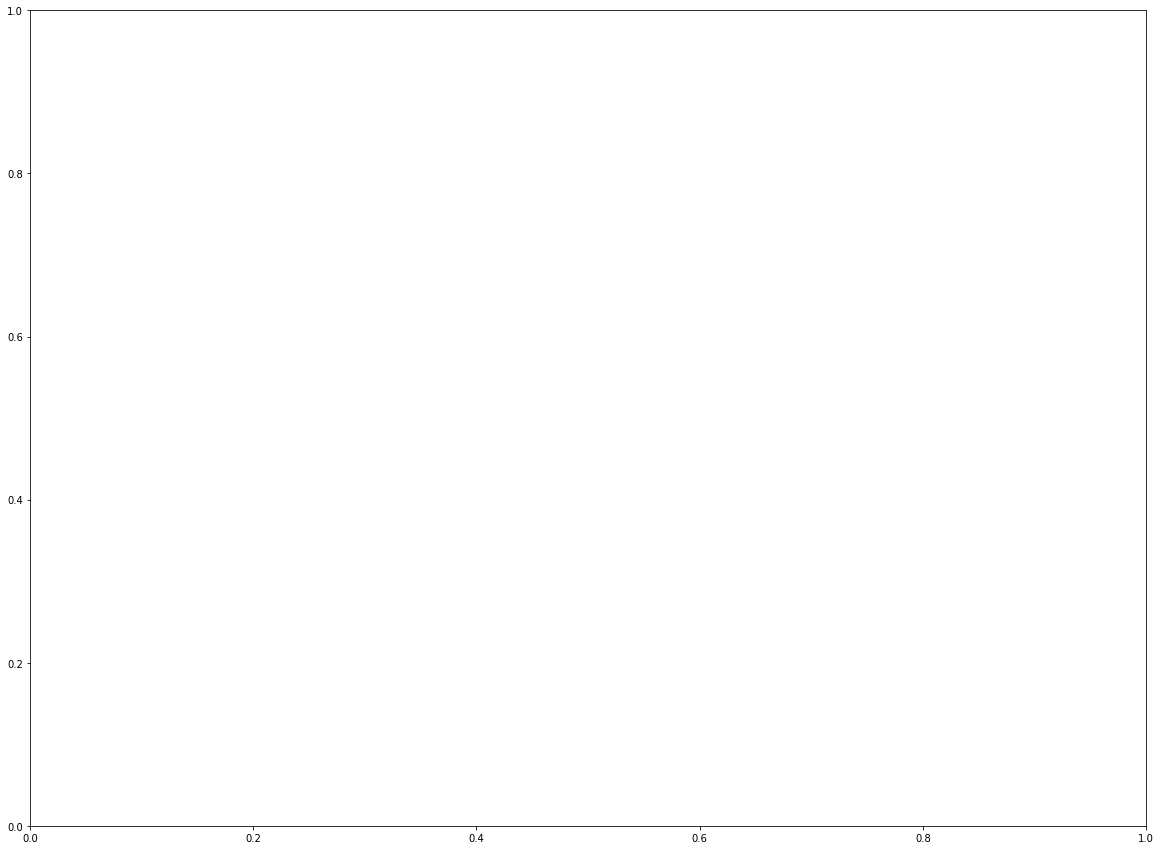

In [13]:
fig, ax = plt.subplots(figsize=(20,15))

for key, grp in df_year[df_year.sales_counts > 2000].groupby(['neighborhood']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='relative_price', label=key)

plt.legend(loc='best')
plt.show()

In [ ]:
df_year[df_year.sales_counts > 2000]

In [ ]:
df_year

In [ ]:
def year_analysis(group):

    # for each donor, get first and last donation
    group['donor_name'] = group.last_name
    group['year_donations'] = group.amount.sum()
    group['total_donations'] = df[df.donor_id == group.donor_id.tolist()[0]].amount.sum()
    group['year'] = group.name[0] 

    return group[0:1]

cols = ['donor_id','donor_name','year','year_donations', 'total_donations']

df_year = df.groupby((df['donation_date'].map(lambda x: x.year), df.donor_id)).apply(year_analysis)[cols] #.sort_values('amount', ascending=False).index.values[0:1].tolist()[0]

# remove multilevel index
df_year.index = df_year.index.droplevel(2)
df_year.index = df_year.index.droplevel(1)
df_year.index.name = None


In [ ]:
sales.sale_price.hist()